In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from os.path import join

In [2]:
# Dataframe
path = 'D:\\hse\\3 course\\course_work\\CourseWork2020\\02. News Classifier\\02. Feature Engineering\\Pickles'
path_df = join(path, 'df.pickle')
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = join(path, 'features_train.pickle')
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = join(path, 'labels_train.pickle')
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = join(path, 'features_test.pickle')
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = join(path, 'labels_test.pickle')
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [3]:
print(features_train.shape)
print(features_test.shape)

(1891, 300)
(334, 300)


In [4]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [6]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    7.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=8, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_st...
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
            

In [7]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 1.0, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.9685333333333334


In [8]:
best_lrc = grid_search.best_estimator_

In [9]:
best_lrc

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

In [10]:
best_lrc.fit(features_train, labels_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

In [11]:
lrc_pred = best_lrc.predict(features_test)

In [12]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

The training accuracy is: 
0.9814912744579588


In [13]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The test accuracy is: 
0.9401197604790419


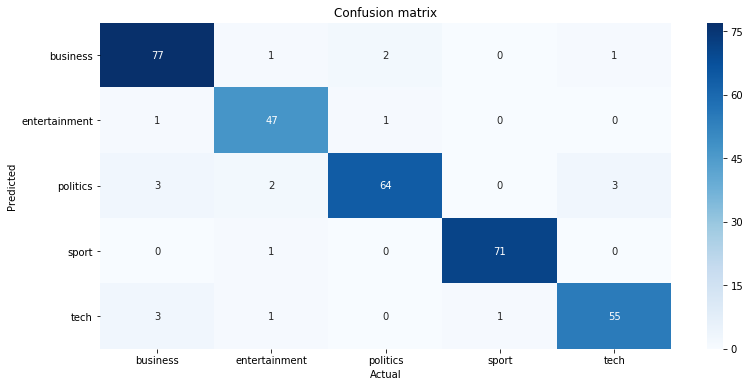

In [14]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()